1. To Run this script do this link and download the following dependencies: 👇

In [7]:
!gdown https://drive.google.com/uc?id=1usW6cF2ntO4WylTYpdQJwFQx7sD_XrM-
!gdown "https://drive.google.com/uc?id=1e2-4xXQKW5H690YEIkgkCmChxe2o8U_B"



/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1usW6cF2ntO4WylTYpdQJwFQx7sD_XrM-
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1usW6cF2ntO4WylTYpdQJwFQx7sD_XrM-/view?usp=sharing
To: /content/view?usp=sharing
103kB [00:00, 36.1MB/s]


In [4]:
!pip install git+https://github.com/openai/CLIP.git ftfy regex tqdm
!pip install pillow

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k4jokccx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-k4jokccx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


Loading CLIP...
Loading detector (custom Faster R-CNN)...


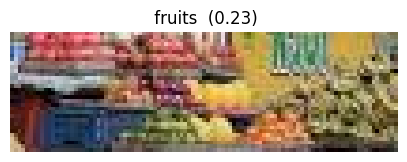

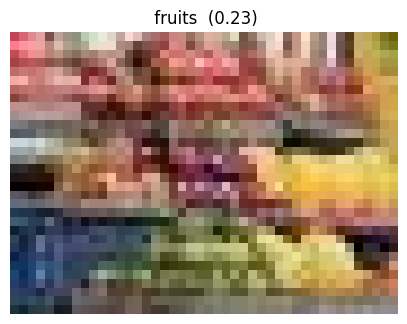

Saved best_crop_1.png with score 0.233
Saved best_crop_2.png with score 0.228


In [5]:
import torch
import clip
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Config (basic settings)
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
# ^ Use GPU if available, otherwise CPU

DETECTOR_SCORE_THRESH = 0.1  # Only keep detected objects with confidence
CLIP_SIM_THRESH = 0.20       # Only keep boxes where CLIP similarity
TOP_K = 2                    # Keep only top 2 best fits
CLIP_MODEL = "ViT-B/32"      # CLIP model version to use

# -------------------------
# Function to load an image from file
def load_image(path):
    return Image.open(path).convert("RGB")

# Function to draw boxes on an image
def draw_boxes_pil(image, boxes, labels=None, scores=None, width=3):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 16)  # Use nice font if available
    except:
        font = ImageFont.load_default()  # Fallback font

    # Loop through each box and draw it
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=width)  # Red rectangle

        text = ""
        if labels is not None:
            text += str(labels[i])
        if scores is not None:
            text += f" {scores[i]:.2f}"

        # Draw the label text above the box
        if text:
            if hasattr(draw, "textbbox"):  # For newer Pillow versions
                tw, th = draw.textbbox((0, 0), text, font=font)[2:]
            else:  # For older Pillow
                tw, th = font.getsize(text)
            draw.rectangle([x1, y1 - th, x1 + tw, y1], fill="red")  # Red background
            draw.text((x1, y1 - th), text, fill="white", font=font)  # White text

    return image

# -------------------------
# Load CLIP model (used to match text with image)
print("Loading CLIP...")
clip_model, clip_preprocess = clip.load(CLIP_MODEL, device=device, jit=False)
clip_model.eval()  # Evaluation mode (no training)

# -------------------------
# Load object detection model (Faster R-CNN)
print("Loading detector (custom Faster R-CNN)...")

# Number of classes in your dataset (including background)
num_classes = 13

# Create model with same structure as trained one
detector = fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)

# Load trained weights
model_path = "/content/fasterrcnn_custom.pth"
detector.load_state_dict(torch.load(model_path, map_location=device))

detector.to(device)
detector.eval()  # Set model to evaluation mode

# Transform: convert image to tensor for model
detector_transform = T.Compose([
    T.ToTensor()
])

# -------------------------
# Main function: detect, crop, and match objects to a prompt
def find_and_crop_multiple(image_pil, prompt, visualize=True, top_k=2):
    # Convert image for detector
    img_tensor = detector_transform(image_pil).to(device)
    with torch.no_grad():  # No training, just detection
        det_out = detector([img_tensor])[0]

    boxes = det_out['boxes'].cpu()      # Object coordinates
    det_scores = det_out['scores'].cpu()  # Confidence scores

    # Filter by confidence score
    keep_idx = (det_scores >= DETECTOR_SCORE_THRESH).nonzero(as_tuple=False).squeeze(1)
    if keep_idx.numel() == 0:
        print("No detector boxes above threshold.")
        return [], [], []

    boxes = boxes[keep_idx].numpy()  # Keep only boxes above threshold

    # Crop each detected object from image
    crops = []
    crop_boxes = []
    for b in boxes:
        x1, y1, x2, y2 = list(map(int, b))
        if x2 <= x1 or y2 <= y1:
            continue  # Skip invalid boxes
        crop = image_pil.crop((x1, y1, x2, y2)).convert("RGB")
        crops.append(crop)
        crop_boxes.append((x1, y1, x2, y2))

    if len(crops) == 0:
        print("No valid crops found.")
        return [], [], []

    # Prepare crops for CLIP
    clip_inputs = torch.stack([clip_preprocess(crop) for crop in crops]).to(device)
    text_tokens = clip.tokenize([prompt]).to(device)

    # Get similarity scores between crops and the text
    with torch.no_grad():
        image_features = clip_model.encode_image(clip_inputs)
        text_features = clip_model.encode_text(text_tokens)

        # Normalize features so they can be compared
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate cosine similarity
        sims = (image_features @ text_features.T).squeeze(1).cpu().numpy()

    # Pick top_k crops with highest similarity
    top_indices = np.argsort(-sims)[:top_k]
    best_crops = [crops[i] for i in top_indices]
    best_boxes = [crop_boxes[i] for i in top_indices]
    best_scores = [sims[i] for i in top_indices]

    # If visualize=True, show the best matches
    if visualize:
        for idx, crop in enumerate(best_crops):
            plt.figure(figsize=(5, 5))
            plt.imshow(crop)
            plt.title(f"{prompt} ({best_scores[idx]:.2f})")
            plt.axis("off")
            plt.show()

    return best_crops, best_boxes, best_scores

# -------------------------
# Example usage / Driver Code
# -------------------------
if __name__ == "__main__":
    image_path = "17.jpg"  # Path to input image
    image = load_image(image_path)

    prompt = " human on bicycle "  # What we are looking for
    crops, boxes, scores = find_and_crop_multiple(image, prompt, visualize=True, top_k=2)

    # Save the best crops to files
    if crops:
        for i, c in enumerate(crops):
            c.save(f"best_crop_{i+1}.png")
            print(f"Saved best_crop_{i+1}.png with score {scores[i]:.3f}")
